In [1]:
import os
import numpy as np
import mne
import osl
import yaml
import pickle
from scipy.io import savemat
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# import distance_riemann
from pyriemann.utils.distance import distance_riemann

In [ ]:
# closest 1 for eeg data
a = np.arange(53).reshape(-1, 1)
pickle.dump(a, open('eeg_closest1', 'wb'))

In [ ]:
rem = ['F7', 'F2', 'F4', 'F6', 'FT9', 'T9', 'P4', 'OZ',
        'F3', 'P1', 'PO7', 'PO3', 'PO4', 'PO8', 'O1', 'O2']

# print indices of channels not to remove
print([i for i, ch in enumerate(epochs[0].info['ch_names']) if ch not in rem])

In [ ]:
keep = ['TP9', 'TP7', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'T7', 'T9', 'TP10', 'TP8', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'T8', 'T10', 'FT7', 'FT8']

# print indices of channels not to remove
print([i for i, ch in enumerate(epochs[0].info['ch_names']) if ch in keep])

In [2]:
raws = []

for i in range(2, 12):
    sid = str(i)
    fif_name = "preproc_preproc_raw.fif"
    base = "/gpfs2/well/woolrich/projects/disp_csaky/eeg/"
    dataset_path = base + f"session{sid}/preproc1_40hz_noica/oslpy/" + fif_name

    # load raw data
    raws.append(mne.io.read_raw_fif(dataset_path, preload=True))

Opening raw data file /gpfs2/well/woolrich/projects/disp_csaky/eeg/session2/preproc1_40hz_noica/oslpy/preproc_preproc_raw.fif...
    Range : 0 ... 3068699 =      0.000 ...  3068.699 secs
Ready.
Reading 0 ... 3068699  =      0.000 ...  3068.699 secs...
Opening raw data file /gpfs2/well/woolrich/projects/disp_csaky/eeg/session3/preproc1_40hz_noica/oslpy/preproc_preproc_raw.fif...
    Range : 0 ... 2754699 =      0.000 ...  2754.699 secs
Ready.
Reading 0 ... 2754699  =      0.000 ...  2754.699 secs...
Opening raw data file /gpfs2/well/woolrich/projects/disp_csaky/eeg/session4/preproc1_40hz_noica/oslpy/preproc_preproc_raw.fif...
    Range : 0 ... 2758099 =      0.000 ...  2758.099 secs
Ready.
Reading 0 ... 2758099  =      0.000 ...  2758.099 secs...
Opening raw data file /gpfs2/well/woolrich/projects/disp_csaky/eeg/session5/preproc1_40hz_noica/oslpy/preproc_preproc_raw.fif...
    Range : 0 ... 2786699 =      0.000 ...  2786.699 secs
Ready.
Reading 0 ... 2786699  =      0.000 ...  2786.699 

In [ ]:
bads = Counter()
for raw in raws:
    bads.update(raw.info['bads'])
print(bads)

In [ ]:
bad_channels = [ch for ch, count in bads.items() if count > 1]
bad_channels

In [ ]:
raws = [raw.drop_channels(bad_channels) for raw in raws]

In [ ]:
# save raws
for i in range(2, 12):
    sid = str(i)
    fif_name = "preproc_preproc_raw.fif"
    base = "/gpfs2/well/woolrich/projects/disp_csaky/eeg/"
    dataset_path = base + f"session{sid}/preproc1_20hz_noica/oslpy/" + fif_name

    # save raw data
    raws[i-2].save(dataset_path, overwrite=True)

In [ ]:
raws[0].plot_sensors(ch_type='eeg', kind='topomap', show_names=True)

In [ ]:
%matplotlib widget
raws[0].plot(n_channels=30, duration=50)
e=0

In [3]:
# find epochs specific to words
event_id = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15}
epoch_event_id = {'words/hungry': 2, 'words/thirst': 3, 'words/tired': 4, 'words/toilet': 5, 'words/pain': 6}

epochs = []
for raw in raws:
    events = mne.events_from_annotations(raw, event_id=event_id)

    event_c = np.array([e[2] for e in events[0]])
    event_t = np.array([e[0] for e in events[0]])

    count1 = 0
    count2 = 0
    new_events = []
    for i, (et, ec) in enumerate(zip(event_t, event_c)):
        if ec < 7 and ec > 1:
            count1 += 1
            if event_c[i+1] == 8:
                new_events.append(np.array([event_t[i+1], 0, ec]))
            else:
                print('error1')
                continue
            if event_c[i+2] == 8:
                new_events.append(np.array([event_t[i+2], 0, ec]))
            else:
                print('error2')
            if event_c[i+3] == 8:
                new_events.append(np.array([event_t[i+3], 0, ec]))
            else:
                print('error3')
            if event_c[i+4] == 8:
                new_events.append(np.array([event_t[i+4], 0, ec]))
            else:
                print('error4')

        elif ec < 16 and ec > 10:
            count2 += 1
            split_events = event_c[i-18:i-4]
            #print(split_events)
            tind = np.nonzero(split_events == 7)[0][-1]

            tind += i-18

            if event_c[tind+1] == 8:
                new_events.append(np.array([event_t[tind+1], 0, ec-9]))
            else:
                print('erorr5')
                print(event_c[i-20:i])
            if event_c[tind+2] == 8:
                new_events.append(np.array([event_t[tind+2], 0, ec-9]))
            else:
                print('erorr6')
                print(event_c[i-20:i])
            if event_c[tind+3] == 8:
                new_events.append(np.array([event_t[tind+3], 0, ec-9]))
            else:
                print('erorr7')
            if event_c[tind+4] == 8:
                new_events.append(np.array([event_t[tind+4], 0, ec-9]))
            else:
                print('erorr8')


    print(count1)
    print(count2)

    new_events = np.array(new_events)

    ep = mne.Epochs(raw,
                    new_events,
                    event_id=epoch_event_id,
                    tmin=-1,
                    tmax=1,
                    baseline=None,
                    picks=['eeg'],
                    reject=None,
                    preload=True)
    epochs.append(ep)

Used Annotations descriptions: ['11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']
176
162
Not setting metadata
1352 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1352 events and 2001 original time points ...


<ipython-input-3-d163d16fc5e5>:69: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  ep = mne.Epochs(raw,


256 bad epochs dropped
Used Annotations descriptions: ['11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']
error1
178
162
Not setting metadata
1356 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1356 events and 2001 original time points ...


<ipython-input-3-d163d16fc5e5>:69: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  ep = mne.Epochs(raw,


213 bad epochs dropped
Used Annotations descriptions: ['11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']
179
162
Not setting metadata
1364 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1364 events and 2001 original time points ...


<ipython-input-3-d163d16fc5e5>:69: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  ep = mne.Epochs(raw,


149 bad epochs dropped
Used Annotations descriptions: ['10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']
182
160
Not setting metadata
1368 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1368 events and 2001 original time points ...


<ipython-input-3-d163d16fc5e5>:69: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  ep = mne.Epochs(raw,


326 bad epochs dropped
Used Annotations descriptions: ['10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']
177
161
Not setting metadata
1352 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1352 events and 2001 original time points ...


<ipython-input-3-d163d16fc5e5>:69: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  ep = mne.Epochs(raw,


104 bad epochs dropped
Used Annotations descriptions: ['10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']
183
160
Not setting metadata
1372 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1372 events and 2001 original time points ...


<ipython-input-3-d163d16fc5e5>:69: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  ep = mne.Epochs(raw,


216 bad epochs dropped
Used Annotations descriptions: ['11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']
183
162
Not setting metadata
1380 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1380 events and 2001 original time points ...


<ipython-input-3-d163d16fc5e5>:69: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  ep = mne.Epochs(raw,


144 bad epochs dropped
Used Annotations descriptions: ['11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']
189
162
Not setting metadata
1404 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1404 events and 2001 original time points ...


<ipython-input-3-d163d16fc5e5>:69: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  ep = mne.Epochs(raw,


154 bad epochs dropped
Used Annotations descriptions: ['11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']
177
162
Not setting metadata
1356 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1356 events and 2001 original time points ...


<ipython-input-3-d163d16fc5e5>:69: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  ep = mne.Epochs(raw,


107 bad epochs dropped
Used Annotations descriptions: ['10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']
188
161
Not setting metadata
1396 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1396 events and 2001 original time points ...


<ipython-input-3-d163d16fc5e5>:69: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  ep = mne.Epochs(raw,


56 bad epochs dropped


In [ ]:
# find epochs specific to words
event_id = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15}
epoch_event_id = {'words/hungry': 2, 'words/thirst': 3, 'words/tired': 4, 'words/toilet': 5, 'words/pain': 6}

epochs = []
for raw in raws:
    events = mne.events_from_annotations(raw, event_id=event_id)

    event_c = np.array([e[2] for e in events[0]])
    event_t = np.array([e[0] for e in events[0]])

    count1 = 0
    count2 = 0
    new_events = []
    for i, (et, ec) in enumerate(zip(event_t, event_c)):
        if ec < 7 and ec > 1:
            count1 += 1
            if event_c[i+1] == 8:
                new_events.append(np.array([event_t[i+1], 0, ec]))
            else:
                print('error1')
                continue

        elif ec < 16 and ec > 10:
            count2 += 1
            split_events = event_c[i-18:i-4]
            #print(split_events)
            tind = np.nonzero(split_events == 7)[0][-1]

            tind += i-18

            if event_c[tind+1] == 8:
                new_events.append(np.array([event_t[tind+1], 0, ec-9]))
            else:
                print('erorr5')
                print(event_c[i-20:i])


    print(count1)
    print(count2)

    new_events = np.array(new_events)

    ep = mne.Epochs(raw,
                    new_events,
                    event_id=epoch_event_id,
                    tmin=0,
                    tmax=4,
                    baseline=None,
                    picks=['eeg'],
                    reject=None,
                    preload=True)
    epochs.append(ep)

In [ ]:
', '.join([f"'{ch}'" for ch in epochs[0].ch_names])

In [ ]:
for i, session in enumerate(epochs):
    sid = str(i+2)
    outdir = base + f"preproc1_20hz_noica/inner_speech_long/sub" + str(i)
    for epoch, event in zip(session, session.events):
        data = epoch.T.astype(np.float32)

        event_id = event[-1]
        os.makedirs(f"{outdir}/cond{event_id-2}", exist_ok=True)
        n_trials = int(len(os.listdir(f"{outdir}/cond{event_id-2}"))/2)
        np.save(f"{outdir}/cond{event_id-2}/trial{n_trials}.npy", data)
        savemat(f"{outdir}/cond{event_id-2}/trial{n_trials}.mat", {'X': data})

In [ ]:
data.shape

In [ ]:
evokeds_avg[0].get_data().shape

In [ ]:
for i, session in enumerate(epochs):
    sid = str(i+2)
    outdir = base + f"preproc1_20hz_noica/inner_speech_long_conv/sub" + str(i)
    evkd = abs(evokeds_avg[i].get_data().T)
    for epoch, event in zip(session, session.events):
        data = epoch.T.astype(np.float32)

        # multiply with evoked
        data = data * evkd

        event_id = event[-1]
        os.makedirs(f"{outdir}/cond{event_id-2}", exist_ok=True)
        n_trials = int(len(os.listdir(f"{outdir}/cond{event_id-2}"))/2)
        np.save(f"{outdir}/cond{event_id-2}/trial{n_trials}.npy", data)
        savemat(f"{outdir}/cond{event_id-2}/trial{n_trials}.mat", {'X': data})

In [ ]:
evokeds_avg = [ep.average() for ep in epochs]

In [ ]:
# construct a sinusoidal wave with a frequency of 10 Hz at 1000 Hz sampling rate
sfreq = 1000
times = np.arange(sfreq) / sfreq
sin = np.sin(2 * np.pi * 10 * times)

evkd_chn = evkd[46][500:1500]

convolved = np.convolve(sin, evkd_chn, mode='same')
convolved = np.convolve(convolved, evkd_chn, mode='same')

%matplotlib widget
fig, ax1 = plt.subplots()
ax1.plot(sin*evkd_chn)

ax2 = ax1.twinx()
ax2.plot(evkd_chn, color='r')

In [ ]:
trials = epochs[0].get_data()
evkd = np.mean(trials, axis=0)

print(trials.shape)
print(evkd.shape)

In [ ]:
# convolve each trial with evoked response
convolved = np.zeros_like(trials)
for ind in range(trials.shape[0]):
    for ch in range(trials.shape[1]):
        #convolved[ind, ch] = np.convolve(trials[ind][ch], evkd[ch], mode='same')
        convolved[ind, ch] = trials[ind][ch]*abs(evkd[ch])

In [ ]:
ind = 256
chn = ch_dict['PO7']

%matplotlib widget
fig, ax1 = plt.subplots()
ax1.plot(trials[ind, chn])

ax2 = ax1.twinx()
ax2.plot(convolved[ind, chn], color='r')

fig, ax1 = plt.subplots()
ax1.plot(evkd[chn])

convolved_evkd = np.mean(convolved, axis=0)
ax2 = ax1.twinx()
ax2.plot(convolved_evkd[chn], color='r')

In [ ]:
# compare evoked responses with variance across trials shown as shading based on the epochs list
fig, ax = plt.subplots(1, 3)
for i, epoch in enumerate(epochs[:2]):
    epoch.plot_image(axes=ax, show=True, picks=['O2'])


In [ ]:
evokeds = {str(i): [] for i in range(10)}
for i, ep in enumerate(epochs):
    for j in range(len(ep)):
        evokeds[str(i)].append(ep[j:j+1].average())

In [ ]:
mne.viz.plot_compare_evokeds(evokeds, picks='eeg', ci=True, combine='gfp')

# limit y axis
plt.ylim(4, None)

In [ ]:
mne.viz.plot_compare_evokeds(evokeds, picks=['PO7'], ci=True)

In [4]:
for ep in epochs:
    ep.info['bads'] = []

In [5]:
all_epochs = mne.concatenate_epochs(epochs)

<ipython-input-5-a79d06a03e4c>:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epochs)


Not setting metadata
11975 matching events found
No baseline correction applied


<ipython-input-5-a79d06a03e4c>:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = mne.concatenate_epochs(epochs)


In [ ]:
# create evoked dict for each condition
evokeds = {str(i): [] for i in range(2, 7)}
for i in range(len(all_epochs)):
    id = all_epochs.events[i, 2]
    evokeds[str(id)].append(all_epochs[i:i+1].average())

In [12]:
all_evkd = all_epochs.average()

# get data
all_evkd = all_evkd.get_data()

In [22]:
# compare patterns with evoked responses for individual channels
path = os.path.join('..',
            'results',
            'disp_epoched',
            'eeg',
            '9sessions_noica',
            'standard_cov_longepochs',
            'patterns_haufe.npy')

patterns = np.load(path)
patterns = patterns.reshape(-1, 53, 201, 5)
patterns = np.mean(patterns, axis=(0))

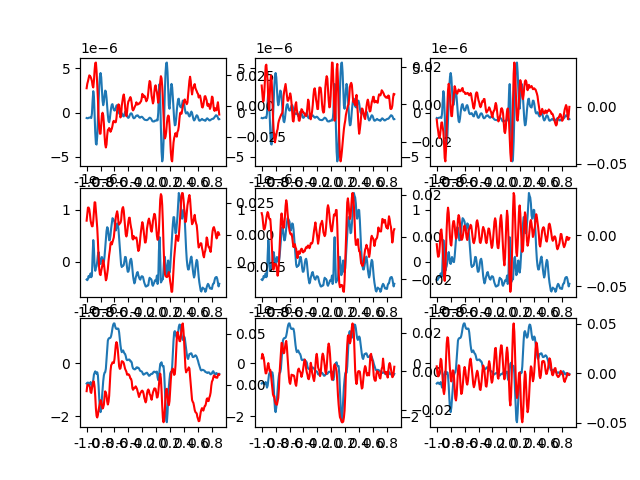

In [46]:
# compare patterns with evoked responses for individual channels
chs = [ch_dict['PO7'], ch_dict['T7'], ch_dict['F8']]

%matplotlib widget

fig, axs = plt.subplots(3, 3)
for i, ch in enumerate(chs):
    for w in range(3):

        axs[i][w].plot(all_evkd[ch][::10], label='evoked')

        ax2 = axs[i][w].twinx()
        ax2.plot(patterns[ch, :, w], label='pattern', color='r')

        plt.xticks(np.arange(0, 201, 21), np.arange(-10, 10, 2)/10) 
e=0

In [ ]:
# plot evoked response (with variance shown) for each element of the epochs list
# create a 2 x 5 subplot and iterate over evokeds to plot into appropriate axes
%matplotlib widget
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i, key in enumerate(evokeds):
    ev = {key: evokeds[key]}
    mne.viz.plot_compare_evokeds(ev, picks=['T7'], ci=True, axes=ax[i], show=False, ylim=dict(eeg=[-2, 2]))

fig.show()

In [ ]:
%matplotlib widget
mne.viz.plot_compare_evokeds(evokeds, picks=['F2'], ci=False)
mne.viz.plot_compare_evokeds(evokeds, picks=['OZ'], ci=False)
mne.viz.plot_compare_evokeds(evokeds, picks=['P3'], ci=False)
mne.viz.plot_compare_evokeds(evokeds, picks=['T9'], ci=False)
mne.viz.plot_compare_evokeds(evokeds, picks=['FT8'], ci=False)
mne.viz.plot_compare_evokeds(evokeds, picks=['C2'], ci=False)

In [ ]:
evkd0 = epochs[0].average()

In [ ]:
# plot evoked response for each channel over the scalp
evkd0.plot_topo()

In [10]:
# build a dict with channel names as keys and indices as values
ch_names = epochs[0].ch_names
ch_dict = {ch_names[i]: i for i in range(len(ch_names))}

In [ ]:
%matplotlib widget
mne.viz.plot_compare_evokeds({'0': evokeds['0']}, picks=['T9'], ci=True)
mne.viz.plot_compare_evokeds({'0': evokeds['1']}, picks=['T9'], ci=True)
mne.viz.plot_compare_evokeds({'0': evokeds['2']}, picks=['T9'], ci=True)

In [ ]:
%matplotlib widget
plt.plot(trials[100, ch_dict['OZ'], :])

In [ ]:
# compute pca over time x trials
pca = PCA(n_components=10)

# fit pca to data
data = trials[:, ch_dict['T9'], :]
pca.fit(data)

# get the principal components
comps = pca.components_

In [ ]:
trials = data

In [ ]:
%matplotlib widget
plt.plot(comps[0])

In [ ]:
model = LinearRegression()
ind = 129

# fit model to data
pca_comp0 = np.repeat(comps[0].reshape(1, -1), data.shape[0], axis=0)
data0 = np.array([np.roll(data[ind], i) for i in range(-50,50)]).T
model.fit(data0, comps[0].T)

# denoise data
denoised = model.predict(data0)

%matplotlib widget
fig, ax1 = plt.subplots()
ax1.plot(data[ind])

ax2 = ax1.twinx()
ax2.plot(denoised.reshape(-1), color='r')

In [ ]:
rolled_ev = np.mean(rolled, axis=0)

In [ ]:
%matplotlib widget
fig, ax1 = plt.subplots()
ax1.plot(rolled_ev[ch_dict['T9'], :])

# make second axis
ax2 = ax1.twinx()
ax2.plot(evkd[ch_dict['T9'], 50:], color='orange')

In [ ]:
# for each trial in trials find the index of the maximum value within the time window
time_window = [350, 450]
max_inds = np.argmax(trials[:, ch_dict['T9'], time_window[0]:time_window[1]], axis=1)
max_inds += time_window[0]

peak = 400
# realign the last dimension of each trial so that max_inds becomes the peak
rolled = []
for i in range(trials.shape[0]):
    trial = np.roll(trials[i], peak - max_inds[i], axis=1)
    rolled.append(trial[:, 50:950])

rolled = np.array(rolled)

In [ ]:
%matplotlib widget
# plot evoked topomap of evokeds
trials = epochs[0].get_data()
for i in range(100):
    plt.plot(trials[i, ch_dict['PO7'], :])

In [ ]:
# plot evoked response (with variance shown) for each element of the epochs list
# create a 2 x 5 subplot and iterate over evokeds to plot into appropriate axes
%matplotlib widget
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i, key in enumerate(evokeds):
    ev = {key: evokeds[key]}
    row = i // 5
    col = i % 5
    mne.viz.plot_compare_evokeds(ev, picks=['T7'], ci=True, axes=ax[row][col], show=False, ylim=dict(eeg=[-2, 2]))

fig.show()

In [ ]:
mne.viz.plot_compare_evokeds({'0': evokeds['0']}, picks=['F6'], ci=True)

In [ ]:
# plot evoked response (with variance shown) for each element of the epochs list
# create a 2 x 5 subplot and iterate over evokeds to plot into appropriate axes
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i, key in enumerate(evokeds):
    ev = {key: evokeds[key]}
    row = i // 5
    col = i % 5
    mne.viz.plot_compare_evokeds(ev, picks=['PO7'], ci=True, axes=ax[row][col], show=False, ylim=dict(eeg=[-6, 6]))

fig.show()

In [ ]:
# plot evoked response (with variance shown) for each element of the epochs list
# create a 2 x 5 subplot and iterate over evokeds to plot into appropriate axes
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i, key in enumerate(evokeds):
    ev = {key: evokeds[key]}
    row = i // 5
    col = i % 5
    mne.viz.plot_compare_evokeds(ev, picks=['C4'], ci=True, axes=ax[row][col], show=False, ylim=dict(eeg=[-2, 2]))

fig.show()

In [ ]:
# plot evoked response (with variance shown) for each element of the epochs list
# create a 2 x 5 subplot and iterate over evokeds to plot into appropriate axes
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i, key in enumerate(evokeds):
    ev = {key: evokeds[key]}
    row = i // 5
    col = i % 5
    mne.viz.plot_compare_evokeds(ev, picks=['F8'], ci=True, axes=ax[row][col], show=False, ylim=dict(eeg=[-3, 3]))

fig.show()

In [ ]:
data = epochs[0].get_data()
data.shape

In [ ]:
data = epochs[0].get_data()
data = data.transpose(1, 2, 0).reshape(data.shape[1], -1)

cov = np.cov(data)

# standardize the data
data = StandardScaler().fit_transform(data.T).T

# compute the covariance matrix
cov_std = np.cov(data)

In [ ]:
# visualize the covariance matrix
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cov)
# modify axis to show channel names
ax[0].set_xticks(range(0, 53, 2), epochs[0].ch_names[::2], rotation=90)

ax[1].imshow(cov_std)
# modify axis to show channel names
ax[1].set_xticks(range(0, 53, 2), epochs[0].ch_names[::2], rotation=90)
e=0

In [ ]:
covs = []
all_covs = []
labels = []
all_full_covs = []
class_labels = []
for sess, ep in enumerate(epochs):
    data = ep.get_data()
    chn = data.shape[1]
    trials = data.shape[0]

    data = data.transpose(1, 2, 0).reshape(data.shape[1], -1)

    # standardize the data
    data = StandardScaler().fit_transform(data.T).T

    data = data.reshape(chn, -1, trials)

    trial_covs = []
    for i in range(trials):
        cov = np.cov(data[:, :, i])
        trial_covs.append(cov)
        all_full_covs.append(cov)

        class_labels.append(ep.events[i, 2])
    
    labels.extend([sess] * trials)

    sess_cov = np.mean(np.array(trial_covs), axis=0)

    '''
    for i in range(trials):
        cov = np.cov(data[:, :, i]) - sess_cov

        mat = np.triu(cov).reshape(-1)
        all_covs.append(mat[mat != 0])
    '''

    covs.append(sess_cov)

In [ ]:
avg_cov = np.mean(np.array(covs), axis=0)

for sess, ep in enumerate(epochs):
    data = ep.get_data()
    chn = data.shape[1]
    trials = data.shape[0]

    data = data.transpose(1, 2, 0).reshape(data.shape[1], -1)

    # standardize the data
    data = StandardScaler().fit_transform(data.T).T

    data = data.reshape(chn, -1, trials)

    d = avg_cov - covs[sess]

    for i in range(trials):
        cov = np.cov(data[:, :, i]) + d

        mat = np.triu(cov).reshape(-1)
        all_covs.append(mat[mat != 0])

In [ ]:
# save session differences
for sess, ep in enumerate(epochs):
    d = avg_cov - covs[sess]
    outdir = base + f"/preproc1_40hz_noica/inner_speech_long/avg_cov_diff{sess}.npy"

    np.save(outdir, d)

In [ ]:
# save session differences
for sess, ep in enumerate(epochs):
    outdir = base + f"/preproc1_40hz_noica/inner_speech_long/cov{sess}.npy"

    np.save(outdir, covs[sess])

In [ ]:
all_full_covs = np.array(all_full_covs)

In [ ]:
# compute mean of covariances across class_labels
class_covs = []
for cl in np.unique(class_labels):
    cov = np.mean(all_full_covs[class_labels == cl], axis=0)
    class_covs.append(cov)

In [ ]:
# visualize the covariance matrix
%matplotlib widget
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i, cov in enumerate(class_covs):
    ax[i].imshow(cov)
    ax[i].set_xticks(range(0, 53, 2), epochs[0].ch_names[::2], rotation=90)

In [ ]:
%matplotlib widget
class_std = np.std(np.array(class_covs), axis=0)/np.mean(np.array(class_covs), axis=0)
plt.imshow(class_std)

In [ ]:
class_std[class_std>1]

In [ ]:
# visualize the covariance matrix
%matplotlib widget
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i, cov in enumerate(covs):
    row = i // 5
    col = i % 5
    ax[row][col].imshow(cov)
    ax[row][col].set_xticks(range(0, 53, 2), epochs[0].ch_names[::2], rotation=90)

In [ ]:
# compute riemannian distance between each session using covs
riemann_dist = []
for i in range(len(covs)):
    dist = []
    for j in range(len(covs)):
        dist.append(distance_riemann(covs[i], covs[j]))

    riemann_dist.append(np.array(dist))

riemann_dist = np.array(riemann_dist)

In [ ]:
np.mean(riemann_dist, axis=0)

In [ ]:
%matplotlib widget
plt.imshow(riemann_dist)

# add colorbar
plt.colorbar()

In [ ]:
avg_cov = np.mean(np.array(covs), axis=0)

# replace each row and column iteratively of each session with avg_cov and compute riemannian distance
riemann_dist = []
for i in range(len(covs)):
    
    dist = []
    for j in range(covs[i].shape[0]):
        cov = covs[i].copy()
        avg_cov_copy = avg_cov.copy()
        cov = np.delete(cov, j, axis=0)
        cov = np.delete(cov, j, axis=1)

        avg_cov_copy = np.delete(avg_cov_copy, j, axis=0)
        avg_cov_copy = np.delete(avg_cov_copy, j, axis=1)

        d = distance_riemann(cov, avg_cov_copy)
        dist.append(d)

    riemann_dist.append(np.array(dist))

riemann_dist = np.mean(np.array(riemann_dist), axis=0)

In [ ]:
# plot scores as topomap
%matplotlib widget
mne.viz.plot_topomap(riemann_dist, epochs[0].info, vmin=5, show_names=True)

In [ ]:
for i, ch in enumerate(epochs[0].info['ch_names']):
    if riemann_dist[i] < 5.3:
        print(i, ch, riemann_dist[i])

In [ ]:
dist
for i in range(len(covs)):
    cov = covs[i].copy()
    avg_cov_copy = avg_cov.copy()
    cov = np.delete(cov, [1, 5, 6, 7, 9, 17, 42, 50], axis=0)
    cov = np.delete(cov, [1, 5, 6, 7, 9, 17, 42, 50], axis=1)

    avg_cov_copy = np.delete(avg_cov_copy, [1, 5, 6, 7, 9, 17, 42, 50], axis=0)
    avg_cov_copy = np.delete(avg_cov_copy, [1, 5, 6, 7, 9, 17, 42, 50], axis=1)

    d = distance_riemann(cov, avg_cov_copy)
    dist.append(d)

np.mean(dist)

In [ ]:
np.mean(sess_riemann_dist)

In [ ]:
# cluster all_covs with KMeans
kmeans = KMeans(n_clusters=6).fit(np.array(all_covs))

In [ ]:
transformed = kmeans.transform(np.array(all_covs))

In [ ]:
# visualize the transformed data
tsne_data = TSNE(n_components=2).fit_transform(np.array(all_covs))

In [ ]:
pca_data = PCA(n_components=10).fit_transform(np.array(all_covs))

In [ ]:
labels = np.array(labels)
class_labels = np.array(class_labels)

In [ ]:
def plot_tsne(tsne_data, labels, ax):
    # Get the unique labels
    unique_labels = np.unique(labels)

    # Plot each cluster with a different color or marker
    for label in unique_labels:
        mask = labels == label
        ax.scatter(tsne_data[mask, 0], tsne_data[mask, 1], label=label, alpha=0.3, s=5)

    # Add a legend
    ax.legend()

In [ ]:
# Create a figure and axis
%matplotlib widget
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
plot_tsne(tsne_data, labels, ax[0])
plot_tsne(tsne_data, kmeans.labels_, ax[1])
plot_tsne(tsne_data, class_labels, ax[2])

In [ ]:
# Create a figure and axis
comps = [0, 1]
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
plot_tsne(pca_data[:, comps], labels, ax[0])
plot_tsne(pca_data[:, comps], kmeans.labels_, ax[1])
plot_tsne(pca_data[:, comps], class_labels, ax[2])

In [ ]:
def session_lda(chid):
    labels = []
    data = []
    for i, ep in enumerate(epochs):
        epoch = ep.get_data()[:, chid, 1000:]
        labels.extend([i] * epoch.shape[0])
        data.append(epoch[: , ::10]*1e6)

    data = np.concatenate(np.array(data), axis=0)

    # train LDA model
    lda = LDA()
    lda.fit(data, labels)

    # get accuracy
    return lda.score(data, labels)

In [ ]:
scores = {}
for i in range(len(epochs[0].ch_names)):
    scores[epochs[0].ch_names[i]] = session_lda(i)

In [ ]:
# plot scores as topomap
%matplotlib widget
mne.viz.plot_topomap(np.array(list(scores.values())), epochs[0].info, vmin=0.1, show_names=True)

In [ ]:
for ch in epochs[0].info['ch_names']:
    if scores[ch] > 0.2:
        print(ch, scores[ch])

In [ ]:
raws[0].plot_sensors(ch_type='eeg', kind='topomap', show_names=True)

In [ ]:
list(scores.values())

In [ ]:
# pick eeg channels
raws[0].get_data().shape

In [ ]:
# load spatial PFI
path = os.path.join('..', 'results', 'disp_epoched', 'eeg', '9sessions_noica', 'standard_cov_longepochs',
                    'val_loss_PFIeeg_closest1.npy')
pfi_ch1 = np.load(open(path, 'rb'))
pfi_ch1 = np.mean(pfi_ch1, axis=0)
pfi_ch1 = pfi_ch1[0, 0] - pfi_ch1[:, 1:]

evoked_ch1 = mne.EvokedArray(pfi_ch1.T, raws[0].info, tmin=0)

%matplotlib widget
evoked_ch1.plot_topomap(times=[0], ch_type='eeg', time_unit='ms', scalings=1, units='Gradient magnitude', time_format='', vmin=0)

In [ ]:
# find indices of channels in pfi_ch1 that are higher than 0.1
chid = []
for i, ch in enumerate(raws[0].info['ch_names']):
    if pfi_ch1[0, i] > 0.1:
        chid.append(i)
        print(ch)

print(chid)